In [181]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
import sqlite3
from langchain_core.tools import tool
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from pydantic.v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks


In [182]:
llm= ChatOpenAI()

In [183]:
connection= sqlite3.connect('employee.db')

In [184]:
connection

In [185]:
table_creation_query= """
CREATE TABLE IF NOT EXISTS employees(
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
""" 

In [186]:
table_creation_query2= """
CREATE TABLE IF NOT EXISTS customers(
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT
);
"""

In [187]:
table_creation_query3= """
CREATE TABLE IF NOT EXISTS orders(
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
    );
    """

In [188]:
cursor= connection.cursor()

In [189]:
cursor.execute(table_creation_query)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [190]:
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""

insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?);
"""


In [191]:
employee_data = [
    (1, "Devendra", "Sharma", "devendra.sharma@abc.com", "2023-07-01", 52000.00),  
    (2, "Arjun", "yadav", "arjun.yadav@gmail.com", "2022-05-10", 62000.00),  
    (3, "john", "vadra", "john.vadra@jpg.com", "2021-10-15", 57000.00),  
    (4, "Robert", "Smith", "robert.smith@uio.com", "2020-02-01", 47000.00),  
]

customers_data = [
    (1, "Rahul", "Yadav", "johnny.doe@newemail.com", "1234567891"),  
    (2, "Mohit", "Shrivastva", "janet.smith@newemail.com", "9876543211"),  
    (3, "Salman", "khusird", "emma.davis@newemail.com", "4567891231"),    
    (4, "Devesh", "choudhary", "mike.brown@newemail.com", "7894561231"),    
]
orders_data = [
    (1, 2, "2023-12-05", 275.50),  
    (2, 1, "2023-11-22", 175.25),  
    (3, 4, "2023-11-28", 325.00),  
    (4, 3, "2023-12-03", 475.75),  
]

In [192]:
cursor.executemany(insert_query,employee_data)

cursor.executemany(insert_query_customers,customers_data)

cursor.executemany(insert_query_orders,orders_data)

connection.commit()
cursor.execute("select * from employees;")

for row in cursor.fetchall():
    print(row)

# cursor.fetchall()

(1, 'Devendra', 'Sharma', 'devendra.sharma@abc.com', '2023-07-01', 52000.0)
(2, 'Arjun', 'yadav', 'arjun.yadav@gmail.com', '2022-05-10', 62000.0)
(3, 'john', 'vadra', 'john.vadra@jpg.com', '2021-10-15', 57000.0)
(4, 'Robert', 'Smith', 'robert.smith@uio.com', '2020-02-01', 47000.0)


In [193]:
cursor.execute("select first_name from employees where salary > 50000.0;")

cursor.fetchall()



[('Devendra',), ('Arjun',), ('john',)]

In [194]:
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")

cursor.fetchall()

[('employees',), ('customers',), ('sqlite_sequence',), ('orders',)]

In [195]:
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")

cursor.fetchall()

[('employees',), ('customers',), ('sqlite_sequence',), ('orders',)]

In [196]:
llm.invoke("hello").content

'Hello! How can I assist you today?'

In [201]:
from langchain_community.utilities import SQLDatabase  
db = SQLDatabase.from_uri("sqlite:///employee.db")    #This is inbuilt langchain class, used to refre sql db('employee.db), it contains many functions those are used to fetch required info from the DB.

In [198]:
query_result = db.run("SELECT * FROM employees ;")
print("Query result from Employees table: \n", query_result)

Query result from Employees table: 
 [(1, 'Devendra', 'Sharma', 'devendra.sharma@abc.com', '2023-07-01', 52000.0), (2, 'Arjun', 'yadav', 'arjun.yadav@gmail.com', '2022-05-10', 62000.0), (3, 'john', 'vadra', 'john.vadra@jpg.com', '2021-10-15', 57000.0), (4, 'Robert', 'Smith', 'robert.smith@uio.com', '2020-02-01', 47000.0)]


In [200]:
print("Dialect:", db.dialect)  # 'dialect' refers to the specific flavor or variant of SQL implemented by a particular database management system (DBMS). each DBMS (like PostgreSQL, MySQL, SQLite, Oracle, Microsoft SQL Server, etc.) has its own extensions, quirks, and slight variations in syntax, data types, functions, and behavior. These variations are collectively referred to as the "dialect" of that DBMS. he dialect property tells you which database backend you're connected to and provides access to dialect-specific features or configurations.
print("Usable tables:", db.get_usable_table_names())

Dialect: sqlite
Usable tables: ['customers', 'employees', 'orders']


In [117]:
query_result = db.run("SELECT * FROM employees ;")
print("Query result from Employees table: \n", query_result)

Query result from Employees table: 
 [(1, 'Devendra', 'Sharma', 'devendra.sharma@abc.com', '2023-07-01', 52000.0), (2, 'Arjun', 'yadav', 'arjun.yadav@gmail.com', '2022-05-10', 62000.0), (3, 'john', 'vadra', 'john.vadra@jpg.com', '2021-10-15', 57000.0), (4, 'Robert', 'Smith', 'robert.smith@uio.com', '2020-02-01', 47000.0)]


In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit     # This provides the 'tools' in SQL DB.
toolkit=SQLDatabaseToolkit(db=db,llm=llm)
tools=toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1170487d0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1170487d0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1170487d0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [119]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [120]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1170487d0>)

In [ ]:
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
get_schema_tool   # Used for getting entire info about the db 

InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x1170487d0>)

In [122]:
print(list_tables_tool.invoke(""))

customers, employees, orders


In [123]:
print(get_schema_tool.invoke("employees"))



CREATE TABLE employees (
	emp_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	hire_date TEXT NOT NULL, 
	salary REAL NOT NULL, 
	PRIMARY KEY (emp_id), 
	UNIQUE (email)
)

/*
3 rows from employees table:
emp_id	first_name	last_name	email	hire_date	salary
1	Devendra	Sharma	devendra.sharma@abc.com	2023-07-01	52000.0
2	Arjun	yadav	arjun.yadav@gmail.com	2022-05-10	62000.0
3	john	vadra	john.vadra@jpg.com	2021-10-15	57000.0
*/


In [202]:
from langchain_core.tools import tool
@tool
def db_query_tool(query: str) -> str:      # This custom tool is going to dot he same work which above done by "query_result = db.run("SELECT * FROM employees #limit 10 ;")"
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result
print(db_query_tool.invoke("SELECT * FROM Employees LIMIT 10;"))

[(1, 'Devendra', 'Sharma', 'devendra.sharma@abc.com', '2023-07-01', 52000.0), (2, 'Arjun', 'yadav', 'arjun.yadav@gmail.com', '2022-05-10', 62000.0), (3, 'john', 'vadra', 'john.vadra@jpg.com', '2021-10-15', 57000.0), (4, 'Robert', 'Smith', 'robert.smith@uio.com', '2020-02-01', 47000.0)]


In [125]:
class Database:
    def run_no_throw(self, query):
        try:
            # Assume `self.connection` is a valid database connection
            cursor = self.connection.cursor()
            cursor.execute(query)
            return cursor.fetchall()  # Or another method to retrieve results
        except Exception as e:
            print(f"Error executing query: {e}")
            return None  # Fallback value

In [ ]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")
class State(TypedDict): #This state means --> message which is going to flow throught the langgraph workflow.
    messages: Annotated[list[AnyMessage], add_messages]
from langchain_core.prompts import ChatPromptTemplate
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])

query_check = query_check_prompt | llm.bind_tools([db_query_tool])

query_check.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LSpbTLfQ8uAOh4M9KURzCnGS', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 224, 'total_tokens': 246, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BfEn2trj3LCf7XNXm3qo38Mop1Mkc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--79206899-0a51-49e9-8ee1-8e92b0b069ea-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_LSpbTLfQ8uAOh4M9KURzCnGS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 22, 'to

In [127]:
query_check.invoke({"messages": [("user", "SELECT + FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WfevxiquGVEVprgkvTSZtBgv', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 224, 'total_tokens': 246, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BfEn3KMniNMezULycaU1mv3nTZVlg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e3a0cf6e-d695-477c-bef3-73218c132428-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_WfevxiquGVEVprgkvTSZtBgv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 22, 'to

In [128]:
# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""


query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([SubmitFinalAnswer])

In [129]:
from langgraph.prebuilt import ToolNode
def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}
def handle_tool_error(state:State) -> dict:
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
        ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],)
        for tc in tool_calls
        ]
    }
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [130]:
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


In [131]:
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [132]:
tools= []
tool_node= ToolNode(tools)
llm_with_tools= llm.bind_tools(tools= tools)

In [133]:
workflow= StateGraph(State)

In [134]:
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
model_get_schema = llm.bind_tools([get_schema_tool])
workflow.add_node("model_get_schema",lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

In [135]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [136]:
app= workflow.compile()

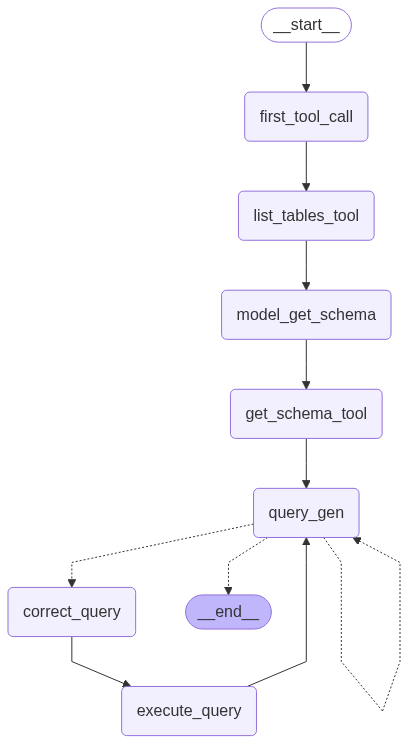

In [137]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [142]:
query={"messages": [("user", "Tell me name of the employee who's salary is more than 55000?")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'john'

In [139]:
query={"messages": [("user", "Tell me about all the orders")]}
response = app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'The orders table has 3 rows with columns order_id, customer_id, order_date, and amount.'

In [141]:
query={"messages": [("user", "Show the phone numbers of customers whose last name is 'yadav'?")]}
response = app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'1234567891'